In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import Lasso

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import shap

c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset

In [ ]:
# Load train and test data
train_df = pd.read_csv("../../data/train_data.csv")
test_df = pd.read_csv("../../data/test_data.csv")

In [3]:
# Assign `is_fraud` column as y
X_train = train_df.loc[:, train_df.columns != 'is_fraud']
y_train = train_df['is_fraud']

X_test = test_df.loc[:, test_df.columns != 'is_fraud']
y_test = test_df['is_fraud']

In [4]:
# Obtain indices for categorical variables
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
categorical_columns_idx = [X_train.columns.get_loc(c) for c in categorical_columns]
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Resampling
# Step 1: Undersample
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=123)
x_under, y_under = undersampler.fit_resample(X_train, y_train)

# Step 2: Oversample with SMOTENC
smotenc = SMOTENC(categorical_features=categorical_columns_idx, 
                  random_state=123, sampling_strategy=0.5)
X_train_resampled, y_train_resampled = smotenc.fit_resample(x_under, y_under)

C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_f

# Train XGBoost + Lasso Model

In [5]:
# Preprocessing
preprocessor=ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ]
)

# Pipeline for each fold
pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(Lasso(alpha=0.001))),
    ('model', xgb.XGBClassifier(use_label_encoder=False, random_state = 123))
])

# Define the hyperparameter grid
param_grid = {
    'model__max_depth': [3, 5, 8],
    'model__learning_rate': [0.1],
    'model__subsample': [0.3, 0.5, 0.8],
    'model__scale_pos_weight': [1],
    'model__eta':[0.1]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', error_score='raise')

# Fit the GridSearchCV object to the training data
start_time = time.time()
grid_search.fit(X_train_resampled, y_train_resampled)
print(f'Duration: {time.time() - start_time} seconds')


C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:07:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:07:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:07:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:08:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:09:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm

Duration: 139.3680260181427 seconds


## Evaluating model performance

In [6]:
# Print the best set of hyperparameters
print("Best set of hyperparameters: ", grid_search.best_params_)

# Get best model and test performance
best_model = grid_search.best_estimator_

Best set of hyperparameters:  {'model__eta': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__scale_pos_weight': 1, 'model__subsample': 0.5}


In [7]:
# Evaluate using cross-validation
sk_folds_lasso = StratifiedKFold(5, shuffle=True, random_state=123)
y_pred_lasso_pipe = cross_val_predict(best_model, X_train_resampled, y_train_resampled, cv=sk_folds_lasso)

# Calculate metrics
auc_lasso_pipe = roc_auc_score(y_train_resampled, y_pred_lasso_pipe)
print("\nLasso Pipeline Results:")
print(f"accuracy: {accuracy_score(y_train_resampled, y_pred_lasso_pipe)}, "
      f"precision: {precision_score(y_train_resampled, y_pred_lasso_pipe, average='macro', zero_division=0.0)}, "
      f"recall: {recall_score(y_train_resampled, y_pred_lasso_pipe, average='macro')}, "
      f"f1: {f1_score(y_train_resampled, y_pred_lasso_pipe, average='macro', zero_division=0.0)}")
print(f'AUC: {round(auc_lasso_pipe, 4)}')

C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:14:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:14:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\PAO2SGP\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [14:14:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(sm


Lasso Pipeline Results:
accuracy: 0.9980811403508771, precision: 0.9979025036626414, recall: 0.9977796052631579, f1: 0.9978410165070555
AUC: 0.9978


### Confusion matrix

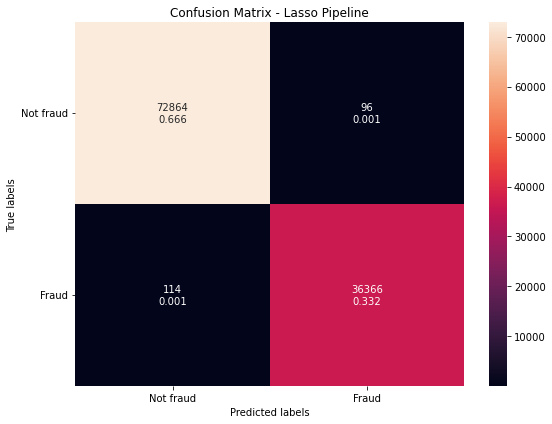

In [8]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_lasso = confusion_matrix(y_train_resampled, y_pred_lasso_pipe)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_lasso.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_lasso.flatten()/np.sum(cm_lasso)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for Lasso Pipeline
ax = plt.subplot()
sns.heatmap(cm_lasso, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Lasso Pipeline')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

## Selected features


Total selected features: 22
Selected features:
1. category_grocery_net
2. category_grocery_pos
3. category_misc_net
4. category_shopping_net
5. trans_quarter_2021Q2
6. trans_quarter_2022Q1
7. amt
8. hour
9. year
10. prev_trans_fraud
11. count_fraud_7days
12. acc_fraud_count
13. merchant_prev_trans_fraud
14. merchant_count_fraud_past7days
15. merchant_acc_fraud_count
16. transaction_risk_score
17. hourly_risk_score
18. visited_cat
19. city_population_class
20. interval
21. first_second_purchase
22. influential_merchant

Top 10 most important features:
                      Feature  Importance
17                visited_cat    0.891064
9            prev_trans_fraud    0.078730
12  merchant_prev_trans_fraud    0.004877
11            acc_fraud_count    0.003404
16          hourly_risk_score    0.002725
6                         amt    0.002514
10          count_fraud_7days    0.002343
7                        hour    0.002100
20      first_second_purchase    0.001111
3       category_shopp

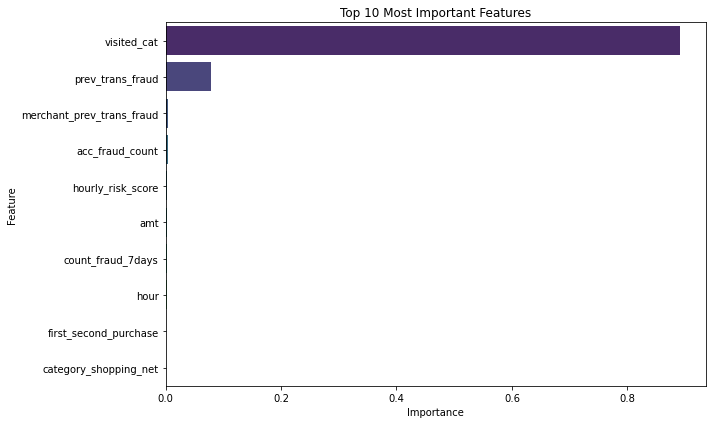

In [11]:
# access Lasso step from pipeline
selector=best_model.named_steps['feature_selection']

feature_names= best_model.named_steps['preprocessor'].get_feature_names_out()
selected_features=feature_names[selector.get_support()]

# Print total count
print(f"\nTotal selected features: {len(selected_features)}")

# Print selected features 
print("Selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature[5:]}")


# Get feature importances from the classifier
feature_importances = best_model.named_steps['model'].feature_importances_

# Create dataframe of importances
importance_df = pd.DataFrame({
    'Feature': [x[5:] for x in selected_features],
    'Importance': feature_importances
})

top10_df = importance_df.sort_values(by='Importance', ascending=False)[:10]

print('\nTop 10 most important features:')
print(top10_df)

# Graph of Features according to their importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top10_df, palette='viridis')
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Test XGBoost + Lasso Model


Test Data Results:
Accuracy: 0.9998
Precision: 0.9674
Recall: 0.9982
F1 Score: 0.9823
AUC: 0.9982


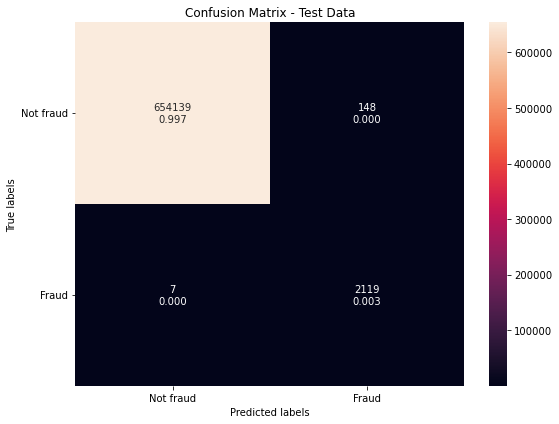

In [10]:
# Use the best model from grid search to predict on test data
y_pred_test = best_model.predict(X_test)

# Calculate evaluation metrics on test data
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='macro', zero_division=0.0)
test_recall = recall_score(y_test, y_pred_test, average='macro')
test_f1 = f1_score(y_test, y_pred_test, average='macro', zero_division=0.0)
test_auc = roc_auc_score(y_test, y_pred_test)

# Print test metrics
print("\nTest Data Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")
print(f"AUC: {test_auc:.4f}")

#  Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, y_pred_test)

# Format text in boxes
group_counts = ["{0:g}".format(value) for value in cm_test.flatten()]
group_percentages = ["{0:.3f}".format(value) for value in cm_test.flatten()/np.sum(cm_test)]
values = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
values = np.asarray(values).reshape(2, 2)

# Create plot for test data
ax = plt.subplot()
sns.heatmap(cm_test, annot=values, fmt='')

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Data')
ax.xaxis.set_ticklabels(['Not fraud', 'Fraud'])
ax.yaxis.set_ticklabels(['Not fraud', 'Fraud'], rotation=0)
plt.tight_layout()
plt.show()

In [105]:
# Obtain test values after preprocessing and applying Lasso
X_test_transformed = best_model.named_steps['feature_selection'].transform(best_model.named_steps['preprocessor'].transform(X_test))
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=[x[5:] for x in selected_features])

# Use SHAP to explain test results
explainer = shap.TreeExplainer(best_model.named_steps['model'])
shap_values = explainer.shap_values(X_test_transformed)

In [106]:
# Identify 1 correctly and 1 incorrectly labelled transaction
test_results = pd.DataFrame(zip(y_pred_test, y_test), columns = ['pred', 'true'])
correct_pred_sample = test_results.loc[test_results['pred'] == test_results['true']].index[0]
wrong_pred_sample = test_results.loc[test_results['pred'] != test_results['true']].index[0]

print(f'Row {correct_pred_sample} was predicted correctly. It was predicted {test_results.at[correct_pred_sample, "pred"]} and was actually {test_results.at[correct_pred_sample, "true"]}.')
print(f'Row {wrong_pred_sample} was predicted incorrectly. It was predicted {test_results.at[wrong_pred_sample, "pred"]} but was actually {test_results.at[wrong_pred_sample, "true"]}.')

Row 0 was predicted correctly. It was predicted 1 and was actually 1.
Row 14371 was predicted incorrectly. It was predicted 1 but was actually 0.


Predicted value for row 0 of test data: 1
True value for row 0 of test data: 1
SHAP plot for row 0 of test data:


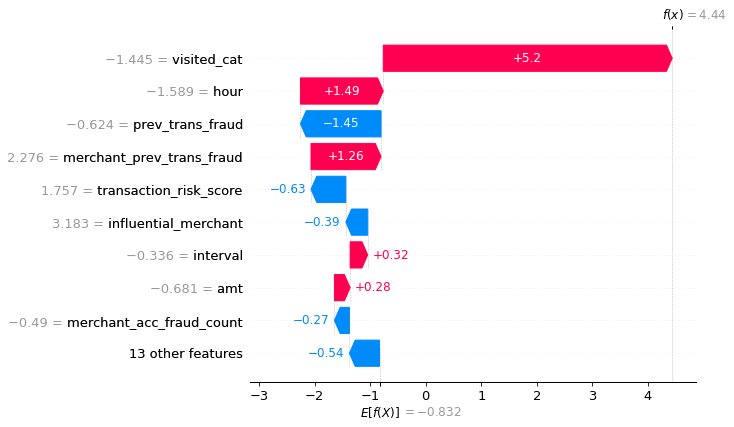

In [107]:
# Plot waterfall plot for correctly labelled transaction
print(f'Predicted value for row 0 of test data: {y_pred_test[0]}')
print(f'True value for row 0 of test data: {y_test[0]}')

explanation_0 = shap.Explanation(values=shap_values[0], 
                                base_values=explainer.expected_value, 
                                data=X_test_transformed_df.iloc[0]) 

print('SHAP plot for row 0 of test data:')
shap.plots.waterfall(explanation_0)

Predicted value for row 14371 of test data: 1
True value for row 14371 of test data: 0
SHAP plot for row 14371 of test data:


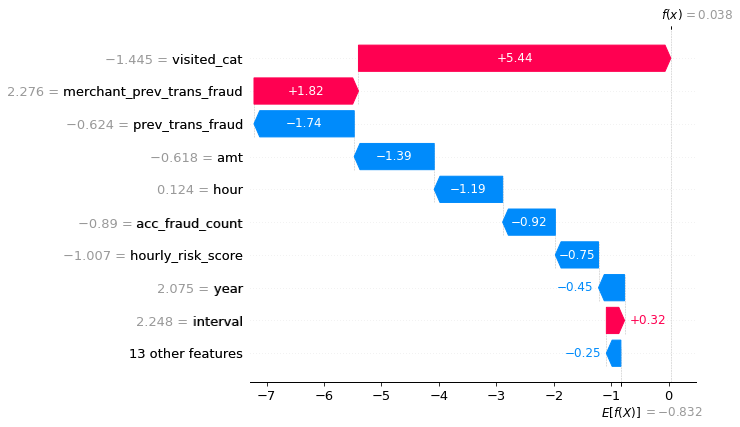

In [108]:
# Plot waterfall plot for incorrectly labelled transaction
print(f'Predicted value for row 14371 of test data: {y_pred_test[14371]}')
print(f'True value for row 14371 of test data: {y_test[14371]}')

explanation_14371 = shap.Explanation(values=shap_values[14371], 
                                base_values=explainer.expected_value, 
                                data=X_test_transformed_df.iloc[14371]) 

print('SHAP plot for row 14371 of test data:')
shap.plots.waterfall(explanation_14371)